In [1]:
import sys
sys.path.append('../../scripts/')
from matplotlib.colors import Normalize, CenteredNorm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#plt.style.use('seaborn-talk') 
plt.style.use('seaborn-v0_8-talk')
from load_SAIdata import Cases
from xarray_funcs import wmean
import cmocean
import cartopy.crs as ccrs
from dask.distributed import LocalCluster, Client
from dask.diagnostics import ProgressBar
import numpy as np
import xarray as xr
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
VAR = 'TREFHT'
DASK_NUM = 1e6 # optimal number of element in dask chunk

In [3]:
# initiate dask cluster for parallel computing
cluster = LocalCluster(n_workers=8) #n_workers=16, threads_per_worker=1, memory_limit="14GiB", processes=True)
client = Client(cluster)
cluster, client

(LocalCluster(a638a567, 'tcp://127.0.0.1:46409', workers=8, threads=16, memory=28.00 GiB),
 <Client: 'tcp://127.0.0.1:46409' processes=8 threads=16, memory=28.00 GiB>)

In [4]:
Cases.cases

{'lres.spinup': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/OUTPUT',
 'lres.sai20': '/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001',
 'lres.sai': '/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001',
 'mres.cnt': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f05_t12/rcp8.5_co2_f05_t12',
 'mres.sai': '/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001',
 'hres.ref.1': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001/OUTPUT',
 'hres.ref.2': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002/OUTPUT',
 'hres.ref.3': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003/OUTPUT',
 'hres.ref.4': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_200

In [5]:
%%time

# opening and preprocessing data
cam = {}
tags = list(Cases.cases)[1:] # exclude spinup
for tag in tags:
    dsi = Cases(tag).select('atm','h0').open_mfdataset(verbose=False) # open data
    dsi = dsi.assign_coords({'time':dsi.time_bnds.mean('nbnd', keep_attrs=True)}) # set time to mid of interval
    valid_times = dsi.time.groupby('time.year').count().sel(year=dsi.time.dt.year) == 12
    tagparts = tag.split('.')
    tagparts.insert(2,'h0')
    tag = '.'.join(tagparts)
    cam[tag] = dsi.isel(time=valid_times) # drop years with less than 12 values
    print(f'{tag}: {cam[tag].time.size/12} complete years')
    
# repeat for yearly averages from mres.control
tags = ['mres.cnt']
for tag in tags:
    dsi = Cases(tag).select('atm','h0.avgYYYY').open_mfdataset(verbose=False) # open data
    dsi = dsi.assign_coords({'time':dsi.time_bnds.mean('nbnd', keep_attrs=True)}) # set time to mid of interval
    #valid_times = dsi.time.groupby('time.year').count().sel(year=dsi.time.dt.year) == 12
    tagparts = tag.split('.')
    tagparts.insert(2,'h0_avgYYYY')
    tag = '.'.join(tagparts)
    cam[tag] = dsi #.isel(time=valid_times) # drop years with less than 12 values
    print(f'{tag}: {cam[tag].time.size} complete years')

lres.sai20.h0: 77.0 complete years
lres.sai.h0: 99.0 complete years
mres.cnt.h0: 74.0 complete years
mres.sai.h0: 54.0 complete years
hres.ref.h0.1: 10.0 complete years
hres.ref.h0.2: 5.0 complete years
hres.ref.h0.3: 5.0 complete years
hres.ref.h0.4: 5.0 complete years
hres.ref.h0.5: 5.0 complete years
hres.ref.h0.6: 2.0 complete years
hres.cnt.h0.1: 5.0 complete years
hres.cnt.h0.2: 5.0 complete years
hres.cnt.h0.3: 5.0 complete years
hres.cnt.h0.4: 5.0 complete years
hres.cnt.h0.5: 5.0 complete years
hres.cnt.h0.6: 5.0 complete years
hres.sai.h0.1: 5.0 complete years
hres.sai.h0.2: 5.0 complete years
hres.sai.h0.3: 5.0 complete years
hres.sai.h0.4: 5.0 complete years
hres.sai.h0.5: 5.0 complete years
hres.sai.h0.6: 2.0 complete years
mres.cnt.h0_avgYYYY: 101 complete years
CPU times: user 6.63 s, sys: 1.39 s, total: 8.02 s
Wall time: 13.5 s


## CAM H0 -- full time series

In [7]:
%%time

# calculate global mean
VARgm = {}
for tag in cam:
    ds = cam[tag]
    ds = ds.chunk({'time':int(DASK_NUM/(ds.lat.size*ds.lon.size))})
    dsm = wmean(ds.TREFHT, ds.gw, ('lat','lon'), keep_attrs=True)
    dsm = dsm.compute()
    VARgm[tag] = dsm
    
# calculate average monthly seasonal cycle
VARmgm = {}
for tag in VARgm:
    if 'h0_avgYYYY' in tag.split('.'):
        VARmgm[tag] = VARgm[tag]
        continue
    VARmgm[tag] = VARgm[tag].groupby('time.month').mean()

# take ensemble average of first five members
for tag in ['hres.ref','hres.cnt','hres.sai']:
    VARmgm[f'{tag}.h0'] = xr.concat([VARmgm[f'{tag}.h0.{i}'] for i in range(1,6)], dim='number').mean('number', keep_attrs=True)
    
# calculate annual mean
annmeans = {}
for tag in VARgm:
    if 'avgYYYY' in tag:
        continue
    w = cam[tag].time_bnds.diff('nbnd').squeeze().astype('int') # month weights
    w = w * w.size/w.sum()
    if tag == 'mres.cnt.h0':
        w[0] = w[12] # time_bnds on first step is less than 31 days, fix manually
    avgtag = tag.replace('h0','h0_avgYYYY')
    if avgtag in VARgm:
        continue # don't overwrite annual mean datasets
    annmeans[avgtag] =  (VARgm[tag]*w).coarsen(time=12).mean(keep_attrs=True)
for avgtag in annmeans:
    VARgm[avgtag] = annmeans[avgtag]

CPU times: user 17.2 s, sys: 1.54 s, total: 18.8 s
Wall time: 1min 2s


In [40]:
# comment out lines below to exclude from plot

kwargs = {
    'lres.sai20.h0': dict(label='LR-SAI2020', lw=1.5, c='lightgray'),
    'lres.sai.h0': dict(label='LR-SAI2050', lw=1.5, c='lightgray'),
    'mres.cnt.h0': dict(label='MR-Control', lw=1.5, c='orangered'),
    'mres.sai.h0': dict(label='MR-SAI2050', lw=1.5, c='dodgerblue'),
    'hres.ref.h0.1': dict(label='HR-Reference', lw=0.5, c='g'),
    'hres.ref.h0.2': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.3': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.4': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.5': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.6': dict(label=None, lw=0.5, c='g'),
    'hres.cnt.h0.1': dict(label='HR-Control', lw=0.5, c='firebrick'),
    'hres.cnt.h0.2': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.3': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.4': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.5': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.6': dict(label=None, lw=0.5, c='firebrick'),
    'hres.sai.h0.1': dict(label='HR-SAI2050', lw=0.5, c='navy'),
    'hres.sai.h0.2': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.3': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.4': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.5': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.6': dict(label=None, lw=0.5, c='navy'),
}

kwargs_avg = {
    'lres.sai20.h0_avgYYYY': dict(label='LR-SAI2020', lw=2.5, c='lightgray'),
    'lres.sai.h0_avgYYYY': dict(label='LR-SAI2050', lw=2.5, c='lightgray'),
    'mres.cnt.h0_avgYYYY': dict(label='MR-Control', lw=2.5, c='orangered'),
    'mres.sai.h0_avgYYYY': dict(label='MR-SAI2050', lw=2.5, c='dodgerblue'),
    'hres.ref.h0_avgYYYY.1': dict(label='HR-Reference', lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.2': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.3': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.4': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.5': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.6': dict(label=None, lw=1.5, c='g'),
    'hres.cnt.h0_avgYYYY.1': dict(label='HR-Control', lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.2': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.3': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.4': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.5': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.6': dict(label=None, lw=1.5, c='firebrick'),
    'hres.sai.h0_avgYYYY.1': dict(label='HR-SAI2050', lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.2': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.3': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.4': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.5': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.6': dict(label=None, lw=1.5, c='navy'),
}

Text(0.5, 1.0, 'annual mean')

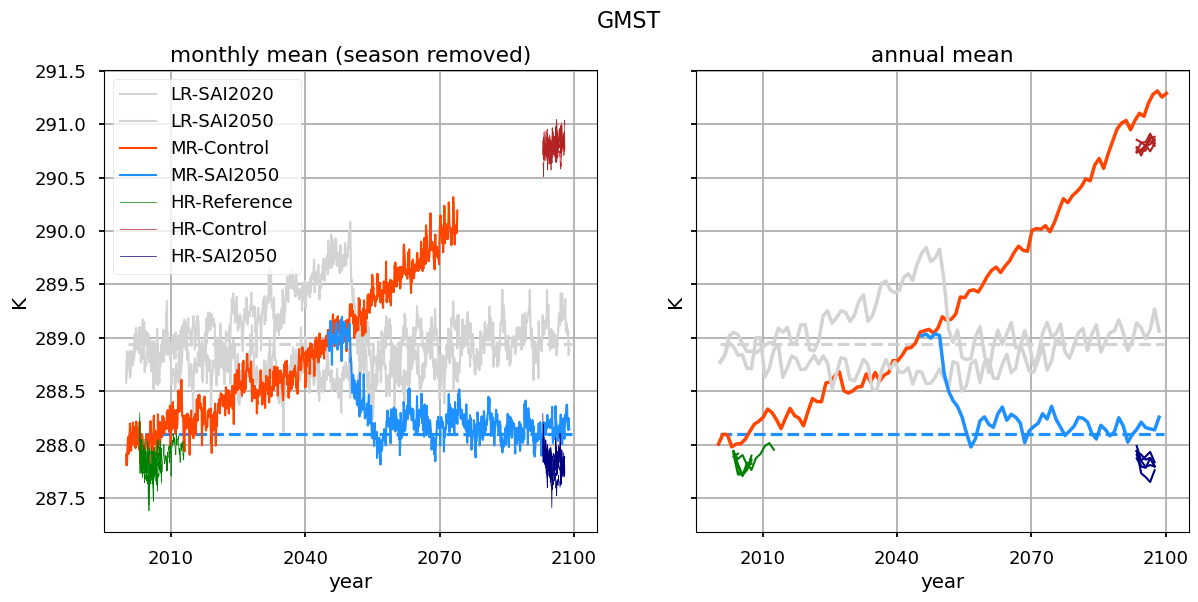

In [51]:
fig, axs = plt.subplots(1,2, figsize=(14,6), sharex=True, sharey=True)
fig.suptitle('GMST', fontsize=16)

# monthly mean plot
ax = axs[0]
ax.axhline(288.93796, xmin=0.05, xmax=0.95, ls='--', c='lightgray')
ax.axhline(288.09713, xmin=0.05, xmax=0.95, ls='--', c='dodgerblue')
for tag in VARgm: # only loop through experiments above
    if tag not in kwargs:
        continue
    shorttag = '.'.join(tag.split('.')[:3]) # tag without ensemble member
    gb = VARmgm[shorttag]
    (VARgm[tag].groupby('time.month')-(gb-gb.mean())).plot(ax=ax, **kwargs[tag])
ax.grid()
ax.set_xlabel('year')
ax.set_ylabel(VARgm['mres.cnt.h0'].units)
ax.set_title('monthly mean (season removed)')
ax.legend()

# annual mean plot
ax = axs[1]
ax.axhline(288.93796, xmin=0.05, xmax=0.95, ls='--', c='lightgray')
ax.axhline(288.09713, xmin=0.05, xmax=0.95, ls='--', c='dodgerblue')
for tag in VARgm: # only loop through experiments above
    if tag not in kwargs_avg:
        continue
    shorttag = '.'.join(tag.split('.')[:3]) # tag without ensemble member
    VARgm[tag].plot(ax=ax, **kwargs_avg[tag])
ax.grid()
ax.set_xlabel('year')
ax.set_ylabel(VARgm['mres.cnt.h0'].units)
ax.set_title('annual mean')
#ax.legend()

## CAM h0 -- maps

In [6]:
def seasonal_average(ds):
    w = ds.time.dt.days_in_month
    w = w.groupby('time.season') / w.groupby('time.season').sum()
    return (ds * w).groupby("time.season").sum(dim="time")

In [7]:
cam_EM = {
    'ref': xr.concat([cam[f'hres.ref.h0.{i}'][[VAR,'time_bnds','gw']] for i in range(1,6)], dim='number').mean('number', keep_attrs=True),
    'cnt': xr.concat([cam[f'hres.cnt.h0.{i}'][[VAR,'time_bnds','gw']] for i in range(1,6)], dim='number').mean('number', keep_attrs=True),
    'sai': xr.concat([cam[f'hres.sai.h0.{i}'][[VAR,'time_bnds','gw']] for i in range(1,6)], dim='number').mean('number', keep_attrs=True),
}

ds = cam_EM['ref']
print(tag, ds.sizes)
print(f"Data points should be divided in {(ds.time.size*ds.lat.size*ds.lon.size)/DASK_NUM:.0f} chunks for optimal performance.")

mres.cnt.h0_avgYYYY Frozen({'lat': 768, 'lon': 1152, 'time': 120})
Data points should be divided in 106 chunks for optimal performance.


In [14]:
%%time
chunks = {'lat':64, 'lon':96} # 12 x 12 chunks
cam_EMTM = {tag: seasonal_average(cam_EM[tag].chunk(chunks)).compute() for tag in cam_EM}

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 405.16 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 202.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 202.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 6.93 s, sys: 1.33 s, total: 8.25 s
Wall time: 8.7 s


0, 1, 2, 3, 

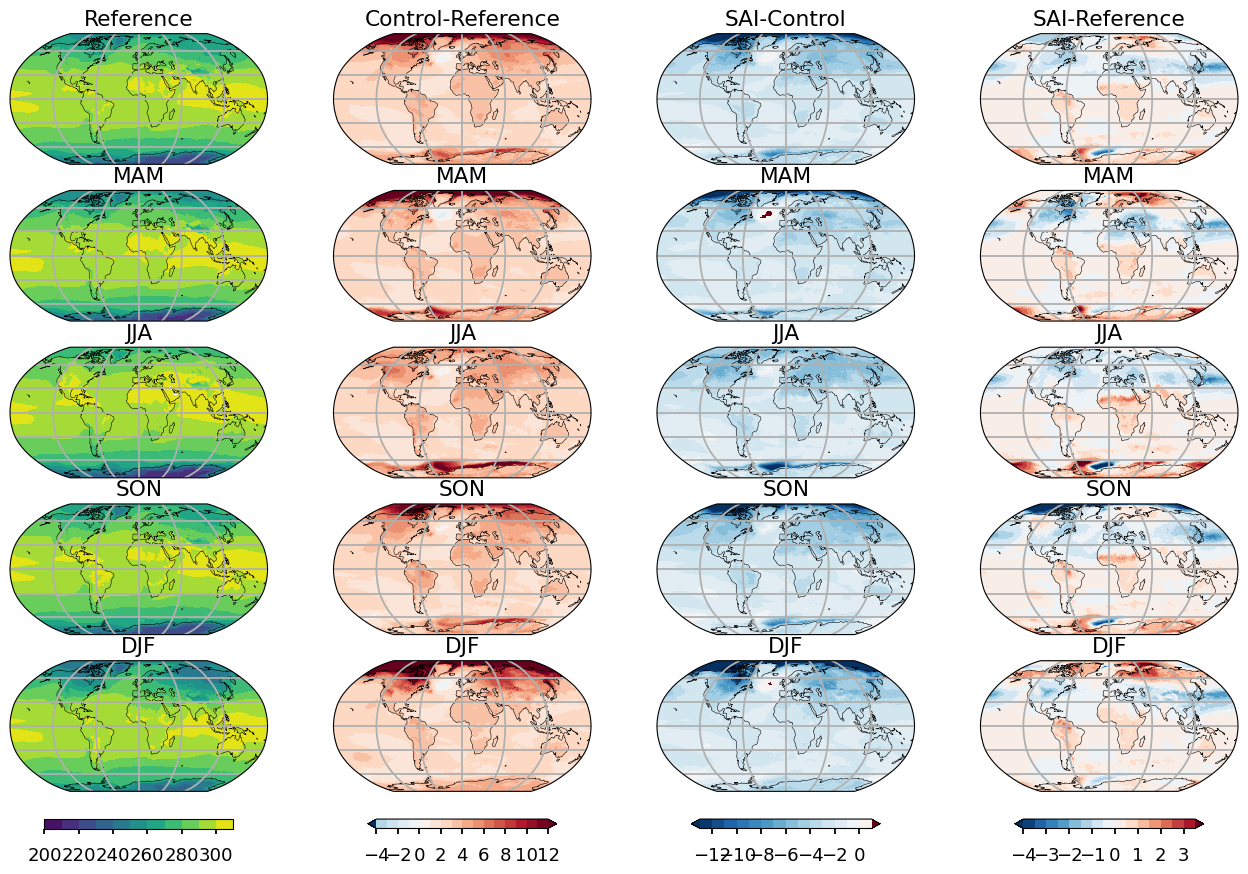

In [18]:
figdata = {
    0: {'title': 'Reference',
        'cfdata': cam_EMTM['ref'],
        'cfkwargs': dict(transform=ccrs.PlateCarree(), levels=range(200,320,10))},
    1: {'title': 'Control-Reference',
        'cfdata': cam_EMTM['cnt'] - cam_EMTM['ref'],
        'cfkwargs': dict(transform=ccrs.PlateCarree(), levels=np.arange(-4,13,1), extend='both', cmap='RdBu_r', norm=CenteredNorm())},
    2: {'title': 'SAI-Control',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['cnt'],
        'cfkwargs': dict(transform=ccrs.PlateCarree(), levels=np.arange(-13,2,1), extend='both', cmap='RdBu_r', norm=CenteredNorm())},
    3: {'title': 'SAI-Reference',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['ref'],
        'cfkwargs': dict(transform=ccrs.PlateCarree(), levels=np.arange(-4,4,0.5), extend='both', cmap='RdBu_r', norm=CenteredNorm())},
}
    
fig, axs = plt.subplots(5,4, figsize=(16,12), subplot_kw={'projection':ccrs.Robinson()})

for col, data in figdata.items():
    print(col, end=', ')
    ds = data['cfdata']
    for ax, season in zip(axs[:,col], ('annual','MAM','JJA','SON','DJF')):
        ax.coastlines()
        ax.gridlines()
        ax.set_title(data['title'] if season=='annual' else season)    
        VARavg = ds[VAR].mean('season') if season=='annual' else ds[VAR].sel(season=season)
        cf = ax.contourf(VARavg.lon, VARavg.lat, VARavg, **data['cfkwargs'])
    fig.colorbar(cf, ax=axs[:,col], orientation='horizontal', shrink=0.7, pad=0.03)